# Dynamic decoupling estimation

In this notebook we try to estimate the effect of dynamical decoupling

## Qiskit imports and backend choice

In [1]:
# Qiskit module
from qiskit import QuantumCircuit

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

# Other imports
import numpy as np

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load IBMQ Account data
from qiskit import IBMQ
IBMQ.load_account()

# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-france', group='univ-montpellier', project='default')
backend = provider.get_backend('ibmq_casablanca')
properties = backend.properties()

## Benchmark circuit preparation

We want to benchmark the dynamical decoupling sequence on several delay durations to know if it is really effective or not. To do so, we start by defining the durations that interest us (in nano-seconds).

In [36]:
durations_dt = list(range(500, 100001, 500))
print(len(durations_dt))

200


### Creating the base circuits

In [37]:
def prepare_circuit(
    qubit: int, pause_time_dt: int, is_fundamental: bool = True
) -> QuantumCircuit:
    circ = QuantumCircuit(7, 1)
    
    if not is_fundamental:
        circ.h(qubit)
    circ.delay(pause_time_dt, qarg=[qubit], unit="dt")
    if not is_fundamental:
        circ.h(qubit)
    circ.measure(qubit, 0)
    
    return circ

In [38]:
def prepare_benchmark_circuits(qubit: int, pause_times: np.ndarray):
    return [
        prepare_circuit(qubit, ptime) for ptime in pause_times
    ] + [
        prepare_circuit(qubit, ptime, False) for ptime in pause_times
    ]

no_dd_circuits = prepare_benchmark_circuits(0, durations_dt)

### Using the tranpiler pass to get equivalent dynamical decoupled circuits

In [39]:
from qiskit.ignis.mitigation.dd.sequences import XY4PulseDynamicalDecouplingSequence, XY4DynamicalDecouplingSequence
from qiskit.ignis.mitigation.dd.passes import DelayToDynamicalDecouplingSequencePass
from qiskit.converters import dag_to_circuit, circuit_to_dag

dd_sequence = XY4DynamicalDecouplingSequence(backend, symmetric=True)
transpiler_pass = DelayToDynamicalDecouplingSequencePass(
    dd_sequence, backend.properties(), backend.configuration().dt
)

dd_circuits = [dag_to_circuit(transpiler_pass.run(circuit_to_dag(c))) for c in no_dd_circuits]

## Merging the circuits and starting to execute them

In [43]:
from qiskit import schedule, transpile

circuits = no_dd_circuits + dd_circuits
tcircuits = [transpile(c, backend, optimization_level=0) for c in circuits]
shots = 8192
initial_layout = list(range(7))
#job = execute(tcircuits,
#              backend, shots=shots, initial_layout=initial_layout)
job = backend.retrieve_job("604a556927d977211f9cde46")
print(job.job_id())

604a556927d977211f9cde46


In [44]:
job_monitor(job)

Job Status: job has successfully run


## Post-processing the data

In [46]:
print("Retrieving result...")
result = job.result()
print("Result done!")
duration_number = len(durations_dt)

data = {
    "xy4": {
        "fundamental": np.zeros((duration_number)),
        "hadamard": np.zeros((duration_number)),
    },
    "nodd": {
        "fundamental": np.zeros((duration_number)),
        "hadamard": np.zeros((duration_number)),
    },
}

dd_offset = 2 * duration_number
for i, state in enumerate(["fundamental", "hadamard"]):
    for j, pause_time in enumerate(durations_dt):
        index = duration_number * i + j
        
        nodd_counts = result.get_counts(index).int_outcomes()
        dd_counts = result.get_counts(dd_offset + index).int_outcomes()

        data["nodd"][state][j] = nodd_counts.get(0, 0) / shots
        data["dd"][state][j] = dd_counts.get(0, 0) / shots

Retrieving result...
Result done!


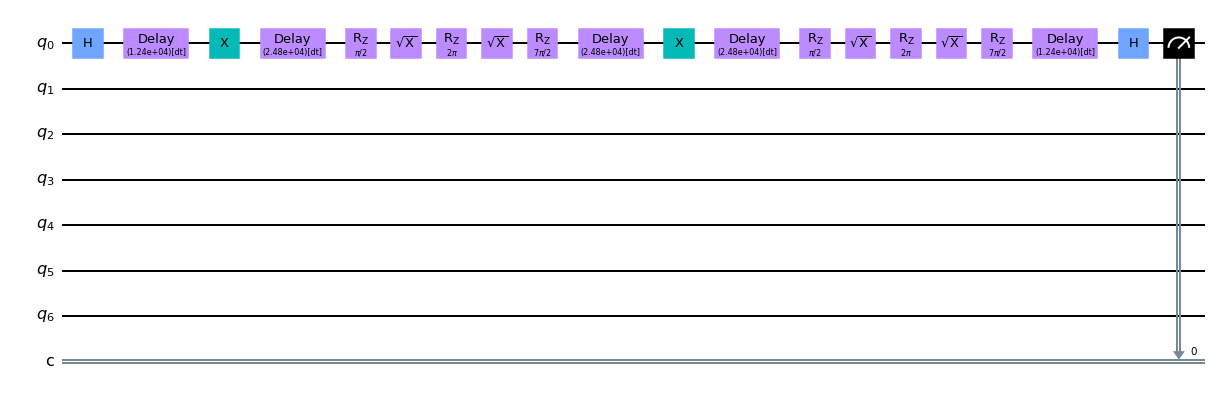

In [62]:
dd_circuits[-1].draw(output="mpl")

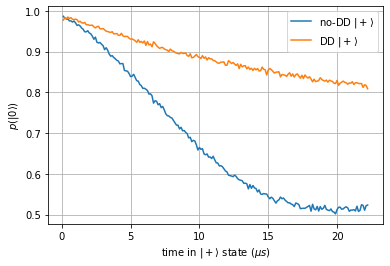

In [59]:
import matplotlib.pyplot as plt

dt = 2/9 * 1e-3
durations_s = [dt * d for d in durations_dt]

plt.plot(durations_s, data["nodd"]["hadamard"], label=r"no-DD $\vert + \rangle$")
plt.plot(durations_s, data["dd"]["hadamard"], label=r"DD $\vert + \rangle$")

plt.xlabel(r"time in $\vert + \rangle$ state ($\mu{}s$)")
plt.ylabel(r"$p(\vert 0 \rangle)$")
plt.grid()
plt.legend()

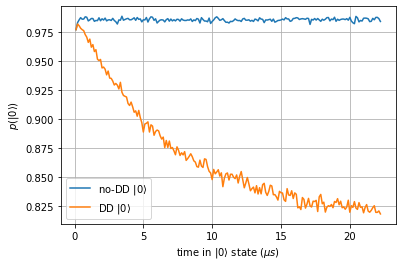

In [60]:
plt.plot(durations_s, data["nodd"]["fundamental"], label=r"no-DD $\vert 0 \rangle$")
plt.plot(durations_s, data["dd"]["fundamental"], label=r"DD $\vert 0 \rangle$")

plt.xlabel(r"time in $\vert 0 \rangle$ state ($\mu{}s$)")
plt.ylabel(r"$p(\vert 0 \rangle)$")
plt.grid()
plt.legend()